# Question 3

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings("ignore")

## Dimension Reduction for question 2: Regression

### 1) Autoencoder 

[68]
[68, 58]
[68, 58, 48]
[68, 58, 48, 38]
[68, 58, 48, 38, 28]
[68, 58, 48, 38, 28, 18]
[68, 58, 48, 38]


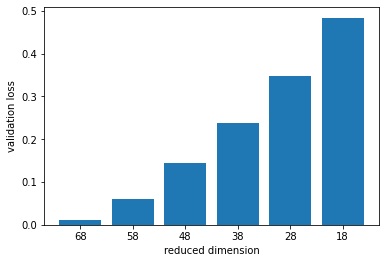

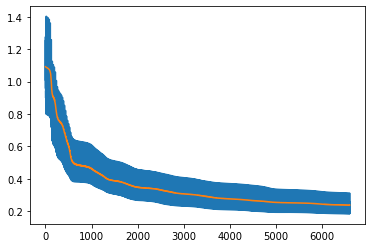

In [18]:
from auto_encoder import Model
import sys
sys.path.append("..") 
from Q1.models import CustomDataset

df = pd.read_csv('../Q2/Reg-Data.csv', header=None)

target_index = -2
X = df.iloc[:, :target_index].values
X = X.astype(np.float32)

y = df.iloc[:, -2:].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# StandardScaler the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_val = sc.transform(X_val)

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

batch_size = 32
epoch = 300
learning_rate = 0.01

input_size = X_train.shape[1]

vals = []
trains = []
total = 6
step = 10
last_vals = []
for j in range(1, total+1):
    hidden_sizes = [input_size - step*i for i in range(0, j)]
    print(hidden_sizes)
    model = Model(input_size=input_size, hidden_sizes=hidden_sizes, batch_size=batch_size)
    loss_trains, loss_vals, loss_test, _, _, _ = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.1)
    trains.append(loss_trains)
    vals.append(loss_vals)
    last_vals.append(loss_vals[-1])


plt.bar([str(input_size - step*i) for i in range(0, total)], last_vals)
plt.xlabel('reduced dimension')
plt.ylabel('validation loss')


plt.figure()
plt.plot(trains[3], label='train')
plt.plot(vals[3], label='validation')

total = 4
hidden_sizes = [input_size - step*i for i in range(0, total)]
print(hidden_sizes)
model = Model(input_size=input_size, hidden_sizes=hidden_sizes, batch_size=batch_size)
_, _, _, encoded_train, encoded_val, encoded_test = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.1)

transoformed_train_dataset = CustomDataset(encoded_train, y_train)
transoformed_val_dataset = CustomDataset(encoded_val, y_val)
transoformed_test_dataset = CustomDataset(encoded_test, y_test)

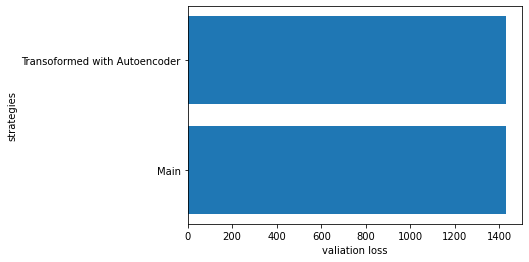

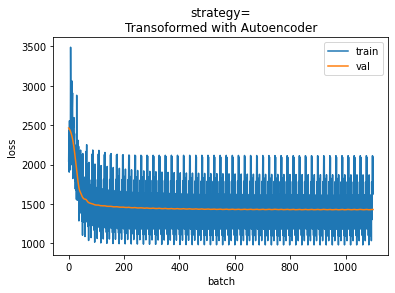

In [20]:
from Q2.models import Model as RegressionModel, plot_loss_acc_comparision, plot_loss_acc
batch_size = 32
epoch = 50
learning_rate = 0.01
loss_trains = []
loss_vals = []
test_losses = []
hidden_layers_num = 1
loss = 'MSE'
optimizer = 'Adam'


model = RegressionModel(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, hidden_layers_num=hidden_layers_num, activation='relu') 
results = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.01)
loss_train, loss_val, test_loss = results
loss_trains.append(loss_train)
loss_vals.append(loss_val)
test_losses.append(test_loss)


model = RegressionModel(input_size=encoded_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, hidden_layers_num=hidden_layers_num, activation='relu') 
results = model.train_evaluate(transoformed_train_dataset, transoformed_val_dataset, transoformed_test_dataset, epochs=epoch, learning_rate=0.01)
loss_train, loss_val, test_loss = results
loss_trains.append(loss_train)
loss_vals.append(loss_val)
test_losses.append(test_loss)


strategies = ['Main', 'Transoformed with Autoencoder']
  
plot_loss_acc_comparision(strategies, 'strategies', loss_vals)

best_validation_loss_arg = np.argmin([loss[-1] for loss in loss_vals])

title = f'strategy=\n{strategies[best_validation_loss_arg]}'
plot_loss_acc(loss_trains[best_validation_loss_arg], loss_vals[best_validation_loss_arg], title)


### 2) PCA

X_train shape: (677, 68)
X_train_pca transformed shape: (677, 39)
X_val_pca transformed shape: (170, 39)
X_test_pca transformed shape: (212, 39)


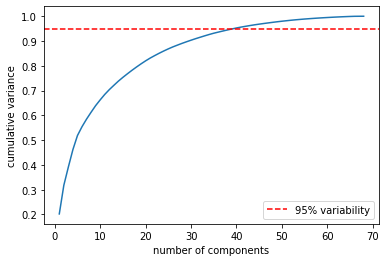

In [22]:
from pca import PCA

input_size = X_train.shape[1]

pca = PCA(input_size)
pca.fit(X_train)
explained_variance_ratio = pca.explained_variance_ratio()
cumulative_variance = np.cumsum(explained_variance_ratio)


plt.plot(range(1, input_size+1),cumulative_variance)
plt.xlabel('number of components')
plt.ylabel('cumulative variance')

plt.axhline(y=0.95, color='r', linestyle='--', label='95% variability')
plt.legend()
best_components = np.argmax(cumulative_variance > 0.95)

pca = PCA(best_components)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)
print(f'X_train shape: {X_train.shape}')
print(f'X_train_pca transformed shape: {X_train_pca.shape}')
print(f'X_val_pca transformed shape: {X_val_pca.shape}')
print(f'X_test_pca transformed shape: {X_test_pca.shape}')

X_train_pca = X_train_pca.astype(np.float32)
X_val_pca = X_val_pca.astype(np.float32)
X_test_pca = X_test_pca.astype(np.float32)

pca_train_dataset = CustomDataset(X_train_pca, y_train)
pca_val_dataset = CustomDataset(X_val_pca, y_val)
pca_test_dataset = CustomDataset(X_test_pca, y_test)

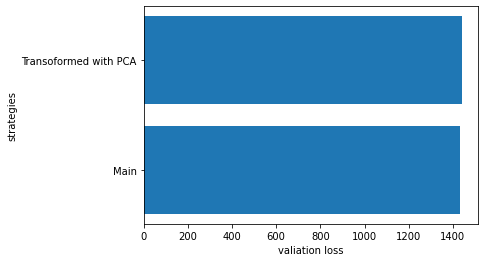

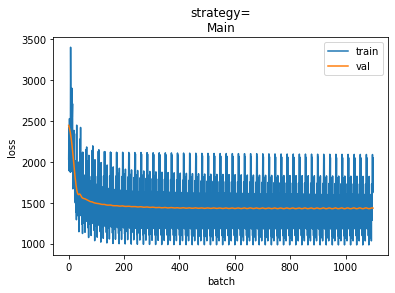

In [24]:
batch_size = 32
epoch = 50
learning_rate = 0.01
loss_trains = []
loss_vals = []
test_losses = []
hidden_layers_num = 1
loss = 'MSE'
optimizer = 'Adam'


model = RegressionModel(input_size=X_train.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, hidden_layers_num=hidden_layers_num, activation='relu') 
results = model.train_evaluate(train_dataset, val_dataset, test_dataset, epochs=epoch, learning_rate=0.01)
loss_train, loss_val, test_loss = results
loss_trains.append(loss_train)
loss_vals.append(loss_val)
test_losses.append(test_loss)


model = RegressionModel(input_size=X_train_pca.shape[1], hidden_size=32, batch_size=batch_size, loss=loss, optimizer=optimizer, hidden_layers_num=hidden_layers_num, activation='relu') 
results = model.train_evaluate(pca_train_dataset, pca_val_dataset, pca_test_dataset, epochs=epoch, learning_rate=0.01)
loss_train, loss_val, test_loss = results
loss_trains.append(loss_train)
loss_vals.append(loss_val)
test_losses.append(test_loss)


strategies = ['Main', 'Transoformed with PCA']
  
plot_loss_acc_comparision(strategies, 'strategies', loss_vals)

best_validation_loss_arg = np.argmin([loss[-1] for loss in loss_vals])

title = f'strategy=\n{strategies[best_validation_loss_arg]}'
plot_loss_acc(loss_trains[best_validation_loss_arg], loss_vals[best_validation_loss_arg], title)